# Part D: A Real Sentiment Analysis Task: 

## Build and Evaluate a Basic Classifier for Subtask A in English

### 1. Process the Data

We provide the path to the folder containing the text files. We read each text file in the folder. We append the tweets one by one in the "raw_data" file.

In [189]:
import glob 
from os.path import isfile
import string
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
import numpy as np

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Yudhi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [121]:
#simple file reader without exception handling
def readFile(path):
    files=filter(isfile,glob.glob('%s/*'%path))
    raw_data =[]
    for name in files:
        with open(name, 'r', encoding='utf-8') as f:
            for line in f:
                record = line.strip().split() 
                raw_data.append(record)
    
    return raw_data # return the preprocessed data

In [122]:
#Read the test and train files from disk and preprocessed them
path = r'S:\IT\Queen Mary\NLP\Assignment 1\EnglishSubtaskA\train'
raw_train = readFile(path)

#for the test set
path = r'S:\IT\Queen Mary\NLP\Assignment 1\EnglishSubtaskA\test'
raw_test = readFile(path)

In [205]:
print("raw data: ", raw_train[6])

raw data:  ['262936443171778560', 'positive', '@mariakaykay', 'aga', 'tayo', 'tomorrow', 'ah.', ':)', 'Good', 'night\\u002c', 'Ces.', 'Love', 'you!', '>:D<']


In [165]:
#function to process the file
def processData(raw_data):
    wordnet_lemma = WordNetLemmatizer()
    stop_list = stopwords.words('english') + list(string.punctuation)
    normalized_data = []
    labels = []
    special = "\\u" # unicode we want to eliminate but keep the word associated with it
    for i in range(len(raw_data)):
        result = [] # clears result after each sentence
        for w in raw_data[i]:
            if special in w:
                idx = w.index(special)
                word = w[:idx] #take only the first part of the word and ignore 'special'
            else:
                word = w # otherwise word stays the same
            word = word.lower() #change word to lower case

            if word not in stop_list and word.isalpha() and len(word) > 1: #filter out punctuations,stop words and digits
                word = wordnet_lemma.lemmatize(word, pos="v") #apply lemmatizer and skip label(positive, etc..)
                result.append(word) #append each word to a phrase
        if len(result) > 3:
            normalized_data.append(result[1:]) #append each phrase to the file
            lab = ''.join(result[:1])
            if lab =="positive":
                labels.append(2)
            elif lab =="negative":
                labels.append(1)
            else:
                labels.append(0)

    return normalized_data,labels

In [171]:
#for the training/validation set
train_processed,train_labels = processData(raw_train)
test_processed,test_labels = processData(raw_test)

Sanity check:

In [172]:
print("Example train data: ", train_processed[6], train_labels[6])
print("Example test data: ", test_processed[6], test_labels[6])

Example train data:  ['aga', 'tayo', 'tomorrow', 'good', 'night', 'love'] 2
Example test data:  ['bolton', 'wanderers', 'leeds', 'sit', 'nav', 'free', 'milton', 'manage', 'write', 'much'] 0


### 2. Find the top words

In [173]:
#function to put all the words together
VOCAB_SIZE = 8000
INDEX_FROM = 2
#put all the words together
def wordsList(normalized_data):
    longsen = []
    for i in range(len(normalized_data)):
        sen = normalized_data[i]
        for w in sen:
            longsen.append(w) #longsen cotains all the words in a list
    return topWordsList(longsen)


In [174]:
#function to find the top occuring words
def topWordsList(longsen):
    top_words = []
    INDEX_FROM = 2
    count = 0
    fdist = nltk.FreqDist(longsen)
    for word, frequency in fdist.most_common():
        #print(u'{};{}'.format(word, frequency))
        if count < (VOCAB_SIZE - INDEX_FROM):
            count += 1
            top_words.append(word)
    return top_words

In [59]:
vocab_words = wordsList(train_processed+test_processed) # get a list of our vocabulary

Fill UNK and START tags in all data

In [175]:
#Starting with training data
def tagList(my_data,topwords):
    tagged_data = []
    for i in range(len(my_data)):
        out = []
        out.append("<START>")
        for w in my_data[i]:
            if w not in topwords:
                w = "<UNK>"
            else:
                w = w
            out.append(w) # one sentence
        tagged_data.append(out) # the whole file
    return tagged_data

In [176]:
tagged_train = tagList(train_processed,vocab_words)
tagged_test = tagList(test_processed,vocab_words)

Sample of tagged data:

In [206]:
print("Tagged train data:",tagged_train[6],", label: ",train_labels[6])
print("Tagged test data:",tagged_test[6], ", label: ", test_labels[6])

Tagged train data: ['<START>', '<UNK>', '<UNK>', 'tomorrow', 'good', 'night', 'love'] , label:  2
Tagged test data: ['<START>', 'bolton', 'wanderers', 'leeds', 'sit', 'nav', 'free', 'milton', 'manage', 'write', 'much'] , label:  0


In [207]:
def wordToIndex(data):
    w2idx = {} # empty dictionary
    w2idx ["<PAD>"] = 0
    w2idx ["<START>"] = 1
    w2idx ["<UNK>"] = 2  
    counter = 3
    for i in range(len(data)):
        for w in data[i]:
            if w not in w2idx.keys():
                w2idx[w] = counter
                counter = counter + 1
    return w2idx


In [208]:
word2idx = wordToIndex(tagged_train+tagged_test)

In [209]:
#reverse the dictionary for index to word
idx2word = dict([[v,k] for k,v in word2idx.items()])

Convert sentences as ids

In [246]:
#sents as ids
def sentID(datFile):
    sents_as_ids = []
    for i in range(len(datFile)):
        converted = [] # empty list for every new line in corpus
        for word in datFile[i]:
            converted.append(word2idx[word]) #create sentence as a list of ids
        sents_as_ids.append(converted)
    return sents_as_ids

Sanity check:

In [247]:
print('Number of unique words: ', len(word2idx))
print('\nSample word2idx: ', list(word2idx.items())[:20])

Number of unique words:  8001

Sample word2idx:  [('<PAD>', 0), ('<START>', 1), ('<UNK>', 2), ('match', 3), ('plus', 4), ('tomorrow', 5), ('busy', 6), ('day', 7), ('awareness', 8), ('areas', 9), ('new', 10), ('england', 11), ('could', 12), ('see', 13), ('first', 14), ('season', 15), ('worst', 16), ('definitely', 17), ('tony', 18), ('man', 19)]


In [248]:
#convert sentences to ids
train_data = sentID(tagged_train)
test_data = sentID(tagged_test)

In [250]:
print("Train data:",tagged_train[6])
print("Training data sentences as ids: ",train_data[6])

Train data: ['<START>', '<UNK>', '<UNK>', 'tomorrow', 'good', 'night', 'love']
Training data sentences as ids:  [1, 2, 2, 5, 48, 49, 50]


In [261]:
#Maximum length of a sentnce
allData = train_data + test_data

### 2. Prepare the Input

In [251]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 30
X_train_enc = pad_sequences(train_data, padding ='pre',maxlen = MAX_LEN,value =0)
X_test_enc = pad_sequences(test_data, padding ='pre',maxlen = MAX_LEN,value =0)

View a padded review:

In [253]:
print(X_train_enc[6])


[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
  2  2  5 48 49 50]


We have about 19000 samples, we will split the data as follows: 3500 for validation and the rest for training

In [254]:
X_val = np.array(X_train_enc[:3500])
partial_X_train = np.array(X_train_enc[3500:])

y_val = np.array(train_labels[:3500])
partial_y_train = np.array(train_labels[3500:])

Decode a tweet (index 6 we have been using so far)

In [255]:
text = X_val[6]
' '.join([idx2word.get(i, '?') for i in text])

'<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> <UNK> <UNK> tomorrow good night love'

### 3. Build the model

In [277]:
# first layer =  embedding layer
#second layer LSTM with max_len units 
#last layer = output layer.choose softmax classification for multiple classes
# Compile model: sparse_categorical_crossentropy, adam optimizer, metrics as accuracy

from keras.models import Model
from keras.layers import Embedding, LSTM, Dense, Input

EMBED_SIZE = 32

main_input = Input(shape=(MAX_LEN,), name='input_1')
layer1= Embedding(VOCAB_SIZE+1,output_dim=EMBED_SIZE, name='Embedding_Layer')(main_input)
layer2 = LSTM(MAX_LEN, name='LSTM_Layer')(layer1)
output = Dense(3, activation = "softmax", name='Output_Layer')(layer2) 
model = Model(inputs=main_input, outputs=output)

model.compile(optimizer = "adam",loss = "sparse_categorical_crossentropy",metrics = ["accuracy"])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30)                0         
_________________________________________________________________
Embedding_Layer (Embedding)  (None, 30, 32)            256032    
_________________________________________________________________
LSTM_Layer (LSTM)            (None, 30)                7560      
_________________________________________________________________
Output_Layer (Dense)         (None, 3)                 93        
Total params: 263,685
Trainable params: 263,685
Non-trainable params: 0
_________________________________________________________________
None


Visualize the model structure

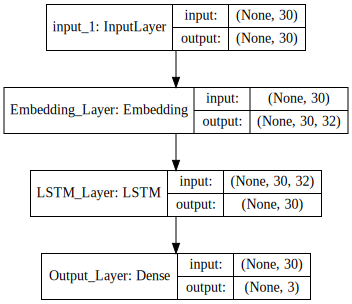

In [278]:
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils import vis_utils

SVG(vis_utils.model_to_dot(model,show_shapes=True, show_layer_names=True).create(prog='dot',format='svg'))

### 4. Training the model

Train the model with different batch sizes and epochs

In [279]:
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs =3,
                    batch_size=100,
                    validation_data=(X_val, y_val),
                    verbose=1)

Train on 16161 samples, validate on 3500 samples
Epoch 1/3
16161/16161 [==============================] - 22s 1ms/step - loss: 0.9865 - acc: 0.4789 - val_loss: 0.9862 - val_acc: 0.5171
Epoch 2/3
16161/16161 [==============================] - 19s 1ms/step - loss: 0.7803 - acc: 0.6382 - val_loss: 0.8868 - val_acc: 0.5914
Epoch 3/3
16161/16161 [==============================] - 18s 1ms/step - loss: 0.6481 - acc: 0.7219 - val_loss: 0.9444 - val_acc: 0.5809


Plotting the accuracy

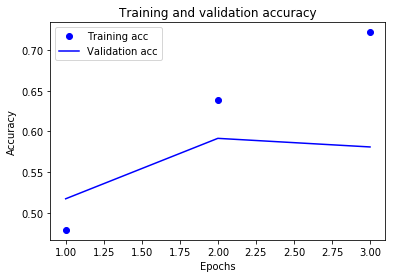

In [280]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 5. Evaluating the model on the test data

In [281]:
results = model.evaluate(X_test_enc, test_labels)

30146/30146 [==============================] - 28s 938us/step


Print results

In [282]:
print('test_loss:', results[0], 'test_accuracy:', results[1])

test_loss: 0.9332514204406662 test_accuracy: 0.5674052942347243


### 6. Extracting the word Embeddings

In [283]:
word_embeddings = model.get_layer('Embedding_Layer').get_weights()[0]

In [284]:
print('Shape of word_embeddings:', word_embeddings.shape)

Shape of word_embeddings: (8001, 32)


### 7. Visualize the Word Embeddings

Sanity check:

In [287]:
from pandas import DataFrame
print(DataFrame(word_embeddings, index=idx2word.values()).tail(10))

                  0         1         2         3         4         5   \
hebdo       0.048374 -0.032764 -0.019848  0.001387 -0.034184  0.007173   
blackstar   0.044714 -0.009867 -0.018663  0.009382 -0.000654  0.033668   
topdawgent  0.036511 -0.024188  0.014463  0.007105 -0.036918  0.017906   
partridge   0.022988 -0.027049 -0.000948  0.036313  0.041829 -0.017726   
kejriwal   -0.040137  0.028103  0.047196  0.021744 -0.019397  0.028229   
aacta      -0.041879  0.030317 -0.036356  0.021507  0.010336 -0.032978   
coles       0.044627 -0.010700  0.012430 -0.011638  0.017108  0.033913   
sampdoria  -0.044425 -0.001319  0.033541 -0.035831 -0.022569  0.000566   
yemen       0.025752 -0.035771 -0.043068  0.008002  0.012257  0.036921   
petrol     -0.033733  0.020183  0.028400  0.038212 -0.048872 -0.040136   

                  6         7         8         9   ...        22        23  \
hebdo      -0.036415 -0.034493 -0.021328  0.046167  ...  0.034306 -0.002937   
blackstar  -0.046303 -0.021

Plot the word embeddings using TSNE

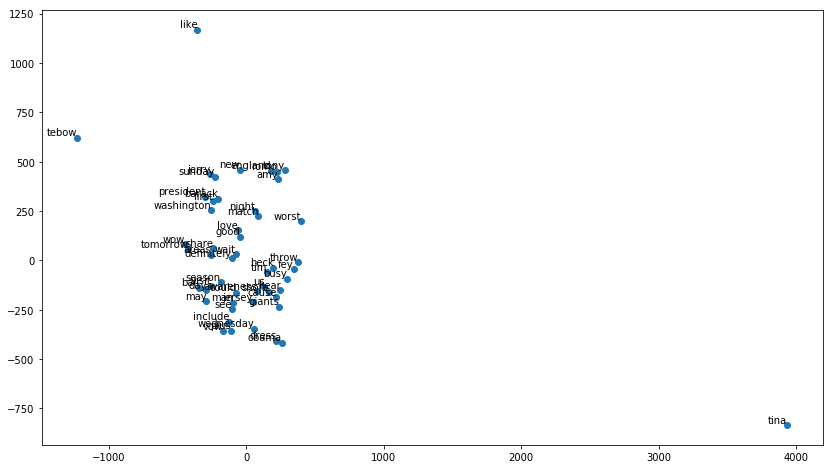

In [271]:
from sklearn.manifold import TSNE
import numpy as np

tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)

# starting from the first word
start = 3
plot_only = 54
T = tsne.fit_transform(word_embeddings[start:plot_only, :])
labels = [idx2word[i] for i in range(start, plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points',ha='right',va='bottom')